In [1]:
# import system libs
import os

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# import Deep learning Libraries
from tensorflow.keras.models import load_model

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## Introduction

### Pneumonia 
Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

(from Kaggel:https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy#Description-of-the-Pneumonia-Dataset)

### Dataset
I obtained a dataset from Kaggle.  

The dataset is organized into three folders (train, test, val), with subfolders for each image category (Pneumonia/Normal). It contains 5,863 X-Ray images (JPEG) and is divided into two categories (Pneumonia/Normal).   

I merged the train and val sets for model training(Normal:1349, P:3883) and the testing set were usedfor model testing(Normal:240, P:390), without using the validation set.

The training parameters for the model are Epochs = 100, Batch Size = 16, Learning Rate = 0.0001.

### Target
The purpose is to detect and classify human diseases from medical images.


## Read Data (Test)

In [2]:
data_dir = '/Users/kang/Desktop/Py_Projects/chest-xray-pneumonia/test'
filepaths = []
labels = []

# Loop over all files in the data directory
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png'):
            # Concatenate the file path with the root directory
            fpath = os.path.join(root, file)
            filepaths.append(fpath)
            # Extract the label from the directory name
            label = os.path.basename(os.path.dirname(fpath))
            labels.append(label)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
df

,filepaths,labels
0,/Users/kang/Desktop/Py_Projects/chest-xray-pne...,PNEUMONIA
1,/Users/kang/Desktop/Py_Projects/chest-xray-pne...,PNEUMONIA
2,/Users/kang/Desktop/Py_Projects/chest-xray-pne...,PNEUMONIA
3,/Users/kang/Desktop/Py_Projects/chest-xray-pne...,PNEUMONIA
4,/Users/kang/Desktop/Py_Projects/chest-xray-pne...,PNEUMONIA
...,...,...
619,/Users/kang/Desktop/Py_Projects/chest-xray-pne...,NORMAL
620,/Users/kang/Desktop/Py_Projects/chest-xray-pne...,NORMAL
621,/Users/kang/Desktop/Py_Projects/chest-xray-pne...,NORMAL
622,/Users/kang/Desktop/Py_Projects/chest-xray-pne...,NORMAL


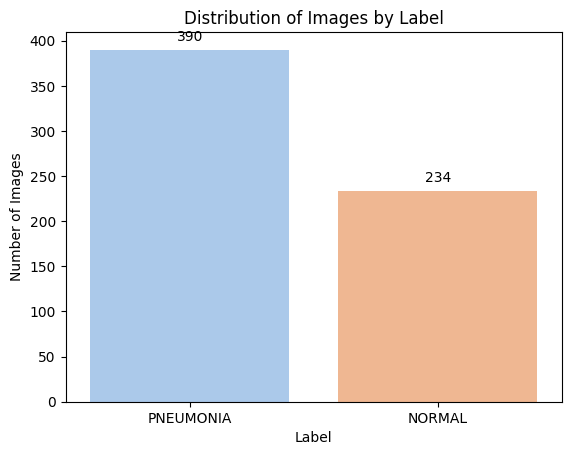

In [4]:
label_counts = df['labels'].value_counts()
colors = sns.color_palette('pastel', len(label_counts))
sns.barplot(x = label_counts.index, y = label_counts.values, palette = colors)
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Label')
for i, v in enumerate(label_counts.values):
    plt.text(i, v+10, str(v), ha='center')

## Load Model

In [5]:
from keras.models import load_model 
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model('/Users/kang/Desktop/Py_Projects/chest-xray-pneumonia/trained model/keras_Model.h5', compile=False)

# Load the labels
with open('/Users/kang/Desktop/Py_Projects/chest-xray-pneumonia/trained model/labels.txt', 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

Metal device set to: Apple M2


2023-04-24 06:36:38.246941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-24 06:36:38.247374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Prediction

In [6]:
from PIL import Image, ImageOps

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
prediction_labels = []
true_labels = df['labels'].tolist()
# Loop over all images in the DataFrame
for i, row in df.iterrows():
    # Load the image
    image = Image.open(row['filepaths']).convert("RGB")

    # Resize and crop the image
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

    # Convert the image to a numpy array and normalize it
    image_array = np.asarray(image)
    normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

    # Load the normalized image into the array
    data[0] = normalized_image_array

    # Predict the class probabilities using the model
    prediction = model.predict(data)

    # Get the index of the class with the highest probability
    index = np.argmax(prediction)

    # Get the name of the predicted class and the confidence score
    class_name = class_names[index]
    prediction_labels.append(class_name[2:])
    confidence_score = prediction[0][index]

    # Print the prediction and confidence score for this image
    #print(f"Image {i}: Class: {class_name}, Confidence Score: {confidence_score}")

2023-04-24 06:36:39.449927: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-24 06:36:39.660354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [7]:
num_correct = sum([1 for i in range(len(prediction_labels)) if prediction_labels[i] == true_labels[i]])
accuracy = num_correct / len(prediction_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6233974358974359
